# **Import библиотек**


In [ ]:
from google.colab import files # модуль для загрузки файлов в colab
import numpy as np #библиотека для работы с массивами данных

from tensorflow.keras.models import Model, load_model # из кераса подгружаем абстрактный класс базовой модели, метод загрузки предобученной модели
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input # из кераса загружаем необходимые слои для нейросети
from tensorflow.keras.optimizers import RMSprop, Adadelta # из кераса загружаем выбранный оптимизатор
from tensorflow.keras.preprocessing.sequence import pad_sequences # загружаем метод ограничения последовательности заданной длиной
from tensorflow.keras.preprocessing.text import Tokenizer # загружаем токенизатор кераса для обработки текста
from tensorflow.keras import utils # загружаем утилиты кераса для one hot кодировки
from tensorflow.keras.utils import plot_model # удобный график для визуализации архитектуры модели
import re
import yaml # импортируем модуль для удобной работы с файлами

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# LIGHT-1

## **Парсинг данных**

In [ ]:
######################
# Открываем файл с диалогами
######################
corpus = open('/content/drive/My Drive/26 Генерация текста/Диалоги(рассказы).yml', 'r') # открываем файл с диалогами в режиме чтения
document = yaml.safe_load(corpus) # загружаем файл *глоссарий
conversations = document['разговоры'] # загружаем диалоги из файла и заносим в conversations 
print('Количество пар вопрос-ответ : {}'.format(len(conversations)))
print('Пример диалога : {}'.format(conversations[123]))

Количество пар вопрос-ответ : 11905
Пример диалога : ['Перезалил?', 'Да вроде бы нет...']


In [ ]:
######################
# Разбираем вопросы-ответы с проставлением тегов ответам
######################
# Собираем вопросы и ответы в списки
questions = list() # здесь будет список вопросов
answers = list() # здесь будет список ответов

# В каждом диалоге берем фразу и добавляем в лист
# Если в ответе не одна фраза - то сцепляем сколько есть
for con in conversations: # для каждой пары вопрос-ответ
  if len(con) > 2 : # если ответ содержит более двух предложений (кол-во реплик, кол-во вариантов ответа)
    questions.append(con[0]) # то вопросительную реплику отправляем в список вопросов
    replies = con[1:] # а ответную составляем из последующих строк
    ans = '' # здесь соберем ответ
    for rep in replies: # каждую реплику в ответной реплике
      ans += ' ' + rep 
    answers.append(ans) #добавим в список ответов
  elif len(con)> 1: # если на 1 вопрос приходится 1 ответ
    questions.append(con[0]) # то вопросительную реплику отправляем в список вопросов
    answers.append(con[1]) # а ответную в список ответов

# Очищаем строки с неопределенным типов ответов
answersCleaned = list()
for i in range(len(answers)):
  if type(answers[i]) == str:
    answersCleaned.append(answers[i]) #если тип - строка, то добавляем в ответы
  else:
    questions.pop(i) # если не строка, то ответ не добавился, и плюс убираем соответствующий вопрос

# Сделаем теги-метки для начала и конца ответов
answers = list()
for i in range(len(answersCleaned)):
  answers.append( '<START> ' + answersCleaned[i] + ' <END>' )

# Выведем обновленные данные на экран
print('Вопрос : {}'.format(questions[200]))
print('Ответ : {}'.format(answers[200]))

Вопрос : Около сотни...
Ответ : <START> Точнее! <END>


In [ ]:
######################
# Подключаем керасовский токенизатор и собираем словарь индексов
######################
tokenizer = Tokenizer()
tokenizer.fit_on_texts(questions + answers) # загружаем в токенизатор список вопросов-ответов для сборки словаря частотности
vocabularyItems = list(tokenizer.word_index.items()) # список с cодержимым словаря
vocabularySize = len(vocabularyItems)+1 # размер словаря
print( 'Фрагмент словаря : {}'.format(vocabularyItems[:50]))
print( 'Размер словаря : {}'.format(vocabularySize))

Фрагмент словаря : [('start', 1), ('end', 2), ('что', 3), ('не', 4), ('я', 5), ('а', 6), ('ты', 7), ('это', 8), ('да', 9), ('в', 10), ('нет', 11), ('как', 12), ('и', 13), ('вы', 14), ('ну', 15), ('с', 16), ('на', 17), ('же', 18), ('так', 19), ('он', 20), ('у', 21), ('кто', 22), ('где', 23), ('все', 24), ('мы', 25), ('то', 26), ('мне', 27), ('тебя', 28), ('меня', 29), ('здесь', 30), ('еще', 31), ('почему', 32), ('о', 33), ('там', 34), ('тебе', 35), ('есть', 36), ('его', 37), ('за', 38), ('куда', 39), ('вот', 40), ('ничего', 41), ('вас', 42), ('знаю', 43), ('чем', 44), ('но', 45), ('она', 46), ('они', 47), ('ли', 48), ('чего', 49), ('вам', 50)]
Размер словаря : 15104


## **Подготовка выборки**

*Разбор данного раздела:* https://youtu.be/LV-ScxAqnMY?t=4906

In [ ]:
######################
# Устанавливаем закодированные входные данные(вопросы)
######################
tokenizedQuestions = tokenizer.texts_to_sequences(questions) # разбиваем текст вопросов на последовательности индексов
maxLenQuestions = max([ len(x) for x in tokenizedQuestions]) # уточняем длину самого большого вопроса
# Делаем последовательности одной длины, заполняя нулями более короткие вопросы
paddedQuestions = pad_sequences(tokenizedQuestions, maxlen=maxLenQuestions, padding='post')

# Предподготавливаем данные для входа в сеть
encoderForInput = np.array(paddedQuestions) # переводим в numpy массив
print('Пример оригинального вопроса на вход : {}'.format(questions[100])) 
print('Пример кодированного вопроса на вход : {}'.format(encoderForInput[100])) 
print('Размеры закодированного массива вопросов на вход : {}'.format(encoderForInput.shape)) 
print('Установленная длина вопросов на вход : {}'.format(maxLenQuestions)) 


Пример оригинального вопроса на вход : Какая же мораль?
Пример кодированного вопроса на вход : [ 170   18 5709    0    0    0    0    0    0    0    0]
Размеры закодированного массива вопросов на вход : (11900, 11)
Установленная длина вопросов на вход : 11


In [ ]:
######################
# Устанавливаем раскодированные входные данные(ответы)
######################
tokenizedAnswers = tokenizer.texts_to_sequences(answers) # разбиваем текст ответов на последовательности индексов
maxLenAnswers = max([len(x) for x in tokenizedAnswers]) # уточняем длину самого большого ответа
# Делаем последовательности одной длины, заполняя нулями более короткие ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers, padding='post')

# Предподготавливаем данные для входа в сеть
decoderForInput = np.array(paddedAnswers) # переводим в numpy массив
print('Пример оригинального ответа на вход: {}'.format(answers[100])) 
print('Пример раскодированного ответа на вход : {}'.format(decoderForInput[100][:30])) 
print('Размеры раскодированного массива ответов на вход : {}'.format(decoderForInput.shape)) 
print('Установленная длина ответов на вход : {}'.format(maxLenAnswers)) 

Пример оригинального ответа на вход: <START> Никакой. Так просто вспомнилось. <END>
Пример раскодированного ответа на вход : [    1   673    19    93 10558     2     0     0     0     0     0     0
     0]
Размеры раскодированного массива ответов на вход : (11900, 13)
Установленная длина ответов на вход : 13


In [ ]:
######################
# Раскодированные выходные данные(ответы)
######################
tokenizedAnswers = tokenizer.texts_to_sequences(answers) # разбиваем текст ответов на последовательности индексов
for i in range(len(tokenizedAnswers)) : # для разбитых на последовательности ответов
  tokenizedAnswers[i] = tokenizedAnswers[i][1:] # избавляемся от тега <START>
# Делаем последовательности одной длины, заполняя нулями более короткие ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers , padding='post')

oneHotAnswers = utils.to_categorical(paddedAnswers, vocabularySize) # переводим в one hot vector
decoderForOutput = np.array(oneHotAnswers) # и сохраняем в виде массива numpy

In [ ]:
print('Пример раскодированного ответа на вход : {}'.format(decoderForInput[100][:21]))  
print('Пример раскодированного ответа на выход : {}'.format(decoderForOutput[100][4][:21])) 
print('Размеры раскодированного массива ответов на выход : {}'.format(decoderForOutput.shape))
print('Установленная длина вопросов на выход : {}'.format(maxLenAnswers)) 

Пример раскодированного ответа на вход : [    1   673    19    93 10558     2     0     0     0     0     0     0
     0]
Пример раскодированного ответа на выход : [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Размеры раскодированного массива ответов на выход : (11900, 13, 15104)
Установленная длина вопросов на выход : 13


## **Параметры нейросети и модель обучения**

*Разбор данного раздела:* https://youtu.be/LV-ScxAqnMY?t=5531

In [ ]:
######################
# Создадим функцию, которая преобразует вопрос пользователя в последовательность индексов
######################
def strToTokens(sentence: str): # функция принимает строку на вход (предложение с вопросом)
  words = sentence.lower().split() # приводит предложение к нижнему регистру и разбирает на слова
  tokensList = list() # здесь будет последовательность токенов/индексов
  for word in words: # для каждого слова в предложении
    tokensList.append(tokenizer.word_index[word]) # определяем токенизатором индекс и добавляем в список

    # Функция вернёт вопрос в виде последовательности индексов, ограниченной длиной самого длинного вопроса из нашей базы вопросов
  return pad_sequences([tokensList], maxlen=maxLenQuestions , padding='post')

In [ ]:
######################
# Создаем рабочую модель для вывода ответов на запросы пользователя
######################
def makeInferenceModels():
  # Определим модель кодера, на входе далее будут закодированные вопросы(encoderForInputs), на выходе состояния state_h, state_c
  encoderModel = Model(encoderInputs, encoderStates) 

  decoderStateInput_h = Input(shape=(200 ,)) # обозначим размерность для входного слоя с состоянием state_h
  decoderStateInput_c = Input(shape=(200 ,)) # обозначим размерность для входного слоя с состоянием state_c

  decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c] # возьмем оба inputs вместе и запишем в decoderStatesInputs

  # Берём ответы, прошедшие через эмбединг, вместе с состояниями и подаём LSTM cлою
  decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding, initial_state=decoderStatesInputs)
  decoderStates = [state_h, state_c] # LSTM даст нам новые состояния
  decoderOutputs = decoderDense(decoderOutputs) # и ответы, которые мы пропустим через полносвязный слой с софтмаксом

  # Определим модель декодера, на входе далее будут раскодированные ответы (decoderForInputs) и состояния
  # на выходе предсказываемый ответ и новые состояния
  decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)

  return encoderModel , decoderModel

In [ ]:
######################
# Первый входной слой, кодер, выходной слой
######################
encoderInputs = Input(shape=(None , )) # размеры на входе сетки (здесь будет encoderForInput)
# Эти данные проходят через слой Embedding (длина словаря, размерность) 
encoderEmbedding = Embedding(vocabularySize, 200 , mask_zero=True) (encoderInputs)
# Затем выход с Embedding пойдёт в LSTM слой, на выходе у которого будет два вектора состояния - state_h , state_c
# Вектора состояния - state_h , state_c зададутся в LSTM слое декодера в блоке ниже
encoderOutputs, state_h , state_c = LSTM(200, return_state=True)(encoderEmbedding)
encoderStates = [state_h, state_c]

In [ ]:
######################
# Второй входной слой, декодер, выходной слой
######################
decoderInputs = Input(shape=(None, )) # размеры на входе сетки (здесь будет decoderForInput)
# Эти данные проходят через слой Embedding (длина словаря, размерность) 
# mask_zero=True - игнорировать нулевые padding при передаче в LSTM. Предотвратит вывод ответа типа: "У меня все хорошо PAD PAD PAD PAD PAD PAD.."
decoderEmbedding = Embedding(vocabularySize, 200, mask_zero=True) (decoderInputs) 
# Затем выход с Embedding пойдёт в LSTM слой, которому передаются вектора состояния - state_h , state_c
decoderLSTM = LSTM(200, return_state=True, return_sequences=True)
decoderOutputs , _ , _ = decoderLSTM (decoderEmbedding, initial_state=encoderStates)
# И от LSTM'а сигнал decoderOutputs пропускаем через полносвязный слой с софтмаксом на выходе
decoderDense = Dense(vocabularySize, activation='softmax') 
output = decoderDense (decoderOutputs)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 200)    3020800     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 200)    3020800     input_2[0][0]                    
_______________________________________________________________________________________

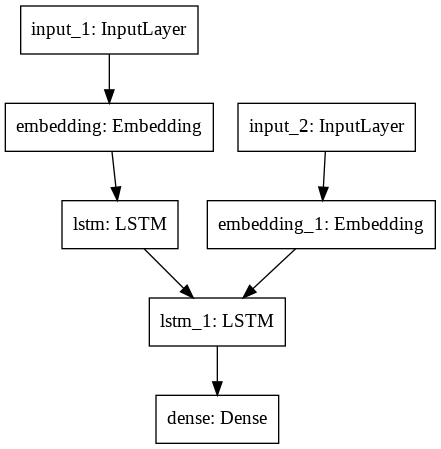

In [ ]:
######################
# Собираем тренировочную модель нейросети
######################
model = Model([encoderInputs, decoderInputs], output)
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy')

print(model.summary()) # выведем на экран информацию о построенной модели нейросети
plot_model(model, to_file='model.png') # и построим график для визуализации слоев и связей между ними

## 20 epoch

In [ ]:
# Запустим обучение и сохраним модель
model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=50, epochs=20) 
# model.save( '/content/drive/My Drive/Предобученные сети/model_30epochs(rms).h5' )

Epoch 1/20
238/238 [==============================] - 10s 43ms/step - loss: 2.2202
Epoch 2/20
238/238 [==============================] - 10s 43ms/step - loss: 1.9783
Epoch 3/20
238/238 [==============================] - 10s 43ms/step - loss: 1.9311
Epoch 4/20
238/238 [==============================] - 10s 43ms/step - loss: 1.8902
Epoch 5/20
238/238 [==============================] - 10s 43ms/step - loss: 1.8546
Epoch 6/20
238/238 [==============================] - 10s 42ms/step - loss: 1.8193
Epoch 7/20
238/238 [==============================] - 10s 43ms/step - loss: 1.7852
Epoch 8/20
238/238 [==============================] - 10s 43ms/step - loss: 1.7526
Epoch 9/20
238/238 [==============================] - 10s 42ms/step - loss: 1.7184
Epoch 10/20
238/238 [==============================] - 10s 43ms/step - loss: 1.6852
Epoch 11/20
238/238 [==============================] - 10s 43ms/step - loss: 1.6510
Epoch 12/20
238/238 [==============================] - 10s 43ms/step - loss: 1.6148
E

In [ ]:
# обернем общение с сетью в функцию, чтобы не копировать этот текст постоянно
def start_chat(num_steps=3):
  encModel , decModel = makeInferenceModels() # запускаем функцию для построения модели кодера и декодера

  for _ in range(num_steps): # задаем количество вопросов, и на каждой итерации в этом диапазоне:
    # Получаем значения состояний, которые определит кодер в соответствии с заданным вопросом
    statesValues = encModel.predict(strToTokens(input( 'Задайте вопрос : ' )))
    # Создаём пустой массив размером (1, 1)
    emptyTargetSeq = np.zeros((1, 1))    
    emptyTargetSeq[0, 0] = tokenizer.word_index['start'] # положим в пустую последовательность начальное слово 'start' в виде индекса

    stopCondition = False # зададим условие, при срабатывании которого, прекратится генерация очередного слова
    decodedTranslation = '' # здесь будет собираться генерируемый ответ
    while not stopCondition : # пока не сработало стоп-условие
      # В модель декодера подадим пустую последовательность со словом 'start' и состояния предсказанные кодером по заданному вопросу.
      # декодер заменит слово 'start' предсказанным сгенерированным словом и обновит состояния
      decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
      
      #argmax пробежит по вектору decOutputs'а[0,0,15104], найдет макс.значение, и вернёт нам номер индекса под которым оно лежит в массиве
      sampledWordIndex = np.argmax( decOutputs[0, 0, :]) # argmax возьмем от оси, в которой 15104 элементов. Получили индекс предсказанного слова.
      sampledWord = None # создаем переменную, в которую положим слово, преобразованное на естественный язык
      for word , index in tokenizer.word_index.items():
        if sampledWordIndex == index: # если индекс выбранного слова соответствует какому-то индексу из словаря
          decodedTranslation += ' {}'.format(word) # слово, идущее под этим индексом в словаре, добавляется в итоговый ответ 
          sampledWord = word # выбранное слово фиксируем в переменную sampledWord
      
      # Если выбранным словом оказывается 'end' либо если сгенерированный ответ превышает заданную максимальную длину ответа
      if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
        stopCondition = True # то срабатывает стоп-условие и прекращаем генерацию

      emptyTargetSeq = np.zeros((1, 1)) # создаем пустой массив
      emptyTargetSeq[0, 0] = sampledWordIndex # заносим туда индекс выбранного слова
      statesValues = [h, c] # и состояния, обновленные декодером
      # и продолжаем цикл с обновленными параметрами
    
    print(decodedTranslation[:-3]) # выводим ответ сгенерированный декодером

In [ ]:
start_chat()

Задайте вопрос : хочешь есть
 нет 
Задайте вопрос : почему сегодня тепло
 не знаю 
Задайте вопрос : как нужно отвечать
 все нормально 


## +30 epochs

In [ ]:
# Запустим обучение и сохраним модель
model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=50, epochs=30) 
# model.save( '/content/drive/My Drive/Предобученные сети/model_30epochs(rms).h5' )

Epoch 1/30
238/238 [==============================] - 10s 41ms/step - loss: 1.3482
Epoch 2/30
238/238 [==============================] - 10s 40ms/step - loss: 1.3191
Epoch 3/30
238/238 [==============================] - 10s 40ms/step - loss: 1.2918
Epoch 4/30
238/238 [==============================] - 10s 41ms/step - loss: 1.2646
Epoch 5/30
238/238 [==============================] - 10s 41ms/step - loss: 1.2370
Epoch 6/30
238/238 [==============================] - 10s 41ms/step - loss: 1.2104
Epoch 7/30
238/238 [==============================] - 10s 41ms/step - loss: 1.1864
Epoch 8/30
238/238 [==============================] - 10s 41ms/step - loss: 1.1634
Epoch 9/30
238/238 [==============================] - 10s 41ms/step - loss: 1.1415
Epoch 10/30
238/238 [==============================] - 10s 40ms/step - loss: 1.1211
Epoch 11/30
238/238 [==============================] - 10s 41ms/step - loss: 1.1019
Epoch 12/30
238/238 [==============================] - 10s 41ms/step - loss: 1.0848
E

In [ ]:
start_chat()

Задайте вопрос : хочешь есть
 есть 
Задайте вопрос : почему сегодня тепло
 не думаю 
Задайте вопрос : как нужно отвечать
 ты его уверен 


## +50 epochs

In [ ]:
# Запустим обучение и сохраним модель
model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=50, epochs=50) 
# model.save( '/content/drive/My Drive/Предобученные сети/model_30epochs(rms).h5' )

Epoch 1/50
238/238 [==============================] - 10s 41ms/step - loss: 0.8590
Epoch 2/50
238/238 [==============================] - 10s 41ms/step - loss: 0.8559
Epoch 3/50
238/238 [==============================] - 10s 41ms/step - loss: 0.8524
Epoch 4/50
238/238 [==============================] - 10s 41ms/step - loss: 0.8485
Epoch 5/50
238/238 [==============================] - 10s 41ms/step - loss: 0.8453
Epoch 6/50
238/238 [==============================] - 10s 41ms/step - loss: 0.8414
Epoch 7/50
238/238 [==============================] - 10s 41ms/step - loss: 0.8388
Epoch 8/50
238/238 [==============================] - 10s 41ms/step - loss: 0.8352
Epoch 9/50
238/238 [==============================] - 10s 41ms/step - loss: 0.8320
Epoch 10/50
238/238 [==============================] - 10s 41ms/step - loss: 0.8289
Epoch 11/50
238/238 [==============================] - 10s 42ms/step - loss: 0.8259
Epoch 12/50
238/238 [==============================] - 10s 42ms/step - loss: 0.8235
E

In [ ]:
start_chat()

Задайте вопрос : хочешь есть
 давай 
Задайте вопрос : почему сегодня тепло
 не думаю 
Задайте вопрос : как нужно отвечать
 ты и что случилось 


## Выводы

Может так случайно вышло, но на первых 20 эпохах ответы получились более адекватными. Однако, думаю, что это случайность. И так как ошибка продолжает снижаться, то необходимо дальнейшее обучение. Видно, что с обучением сеть пытается ответить большим количеством слов, а не односложными ответами как в начале обучения.


# Pro - 1

Пункт первый задания по распознанию слов, на которых сеть не обучалась, встроил сразу в определение токенайзера, а также в функцию перевода вопроса в индексы (использовал text_to_sequences вместо word_index). Получается, что все незнакомые слова сеть интерпретирует как unkonown с индексом 1

Второй пункт разбил на две части: сначала оставил знаки препинания "как есть", то есть вместе со словами. Таким образом при разбивке токенайзером слово со знаком препинания воспринималось как другое слово. Таким образом сильно расширился словарь слов. А при встрече известного слова, но ссо знаком препинания, с которым в тексте оно не стречалось,это слово интерпретировалось как unknown.

Потом перед токенизированием я добавил пробелы перед каждым знаком препинания, чтобы токенайзер воспринимал каждый знак препинания как отдельное слово и давал ему свой индекс. Словарь при этом увеличился, но не так сильно как в предыдущем пункте, но увеличился максимальный размер ответа и вопроса. 

На мой взгляд добавление знаков ухудшило сеть. При этом токенизация знаков препинания как отдельного слово дает лучше результаты.

## Знаки препинания вместе со словами

In [ ]:

tokenizer = Tokenizer(filters='"#$%&()*+/<=>@[\\]^_`{|}~\t\n', oov_token='unknown', char_level=False, split=' ')

tokenizer.fit_on_texts(questions + answers) # загружаем в токенизатор список вопросов-ответов для сборки словаря частотности
vocabularyItems = list(tokenizer.word_index.items()) # список с cодержимым словаря

vocabularySize = len(vocabularyItems)+1 # размер словаря
del vocabularyItems


In [ ]:
######################
# Устанавливаем закодированные входные данные(вопросы)
######################
tokenizedQuestions = tokenizer.texts_to_sequences(questions) # разбиваем текст вопросов на последовательности индексов
maxLenQuestions = max([ len(x) for x in tokenizedQuestions]) # уточняем длину самого большого вопроса
# Делаем последовательности одной длины, заполняя нулями более короткие вопросы
paddedQuestions = pad_sequences(tokenizedQuestions, maxlen=maxLenQuestions, padding='post')

# Предподготавливаем данные для входа в сеть
encoderForInput = np.array(paddedQuestions) # переводим в numpy массив
print('Пример оригинального вопроса на вход : {}'.format(questions[100])) 
print('Пример кодированного вопроса на вход : {}'.format(encoderForInput[100])) 
print('Размеры закодированного массива вопросов на вход : {}'.format(encoderForInput.shape)) 
print('Установленная длина вопросов на вход : {}'.format(maxLenQuestions)) 


Пример оригинального вопроса на вход : Какая же мораль?
Пример кодированного вопроса на вход : [ 201   17 6500    0    0    0    0    0    0    0    0]
Размеры закодированного массива вопросов на вход : (11900, 11)
Установленная длина вопросов на вход : 11


In [ ]:
######################
# Устанавливаем раскодированные входные данные(ответы)
######################
tokenizedAnswers = tokenizer.texts_to_sequences(answers) # разбиваем текст ответов на последовательности индексов
maxLenAnswers = max([len(x) for x in tokenizedAnswers]) # уточняем длину самого большого ответа
# Делаем последовательности одной длины, заполняя нулями более короткие ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers, padding='post')

# Предподготавливаем данные для входа в сеть
decoderForInput = np.array(paddedAnswers) # переводим в numpy массив
print('Пример оригинального ответа на вход: {}'.format(answers[100])) 
print('Пример раскодированного ответа на вход : {}'.format(decoderForInput[100][:30])) 
print('Размеры раскодированного массива ответов на вход : {}'.format(decoderForInput.shape)) 
print('Установленная длина ответов на вход : {}'.format(maxLenAnswers)) 

Пример оригинального ответа на вход: <START> Никакой. Так просто вспомнилось. <END>
Пример раскодированного ответа на вход : [    2 14660    21    96 14661     3     0     0     0     0     0     0
     0]
Размеры раскодированного массива ответов на вход : (11900, 13)
Установленная длина ответов на вход : 13


In [ ]:
######################
# Раскодированные выходные данные(ответы)
######################
tokenizedAnswers = tokenizer.texts_to_sequences(answers) # разбиваем текст ответов на последовательности индексов
for i in range(len(tokenizedAnswers)) : # для разбитых на последовательности ответов
  tokenizedAnswers[i] = tokenizedAnswers[i][1:] # избавляемся от тега <START>
# Делаем последовательности одной длины, заполняя нулями более короткие ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers , padding='post')

decoderForOutput = utils.to_categorical(paddedAnswers, vocabularySize) # переводим в one hot vector
# decoderForOutput = np.array(oneHotAnswers) # и сохраняем в виде массива numpy

In [ ]:
type(decoderForOutput)

numpy.ndarray

In [ ]:
print('Пример раскодированного ответа на вход : {}'.format(decoderForInput[100][:21]))  
print('Пример раскодированного ответа на выход : {}'.format(decoderForOutput[100][4][:21])) 
print('Размеры раскодированного массива ответов на выход : {}'.format(decoderForOutput.shape))
print('Установленная длина вопросов на выход : {}'.format(maxLenAnswers)) 

Пример раскодированного ответа на вход : [    2 14660    21    96 14661     3     0     0     0     0     0     0
     0]
Пример раскодированного ответа на выход : [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Размеры раскодированного массива ответов на выход : (11900, 13, 22342)
Установленная длина вопросов на выход : 13


In [ ]:
######################
# Создадим функцию, которая преобразует вопрос пользователя в последовательность индексов
######################
def strToTokens(sentence: str): # функция принимает строку на вход (предложение с вопросом)
  words = sentence.lower().split() # приводит предложение к нижнему регистру и разбирает на слова
  tokensList = list() # здесь будет последовательность токенов/индексов
  for word in words: # для каждого слова в предложении
    tokensList.append(tokenizer.texts_to_sequences([word])[0][0])   # изменено для неизвестных словарю слов
    # tokensList.append(tokenizer.word_index[word]) # определяем токенизатором индекс и добавляем в список

    # Функция вернёт вопрос в виде последовательности индексов, ограниченной длиной самого длинного вопроса из нашей базы вопросов
  return pad_sequences([tokensList], maxlen=maxLenQuestions , padding='post')

In [ ]:
######################
# Создаем рабочую модель для вывода ответов на запросы пользователя
######################
def makeInferenceModels():
  # Определим модель кодера, на входе далее будут закодированные вопросы(encoderForInputs), на выходе состояния state_h, state_c
  encoderModel = Model(encoderInputs, encoderStates) 

  decoderStateInput_h = Input(shape=(200 ,)) # обозначим размерность для входного слоя с состоянием state_h
  decoderStateInput_c = Input(shape=(200 ,)) # обозначим размерность для входного слоя с состоянием state_c

  decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c] # возьмем оба inputs вместе и запишем в decoderStatesInputs

  # Берём ответы, прошедшие через эмбединг, вместе с состояниями и подаём LSTM cлою
  decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding, initial_state=decoderStatesInputs)
  decoderStates = [state_h, state_c] # LSTM даст нам новые состояния
  decoderOutputs = decoderDense(decoderOutputs) # и ответы, которые мы пропустим через полносвязный слой с софтмаксом

  # Определим модель декодера, на входе далее будут раскодированные ответы (decoderForInputs) и состояния
  # на выходе предсказываемый ответ и новые состояния
  decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)

  return encoderModel , decoderModel

In [ ]:
######################
# Первый входной слой, кодер, выходной слой
######################
encoderInputs = Input(shape=(None , )) # размеры на входе сетки (здесь будет encoderForInput)
# Эти данные проходят через слой Embedding (длина словаря, размерность) 
encoderEmbedding = Embedding(vocabularySize, 200 , mask_zero=True) (encoderInputs)
# Затем выход с Embedding пойдёт в LSTM слой, на выходе у которого будет два вектора состояния - state_h , state_c
# Вектора состояния - state_h , state_c зададутся в LSTM слое декодера в блоке ниже
encoderOutputs, state_h , state_c = LSTM(200, return_state=True)(encoderEmbedding)
encoderStates = [state_h, state_c]

In [ ]:
######################
# Второй входной слой, декодер, выходной слой
######################
decoderInputs = Input(shape=(None, )) # размеры на входе сетки (здесь будет decoderForInput)
# Эти данные проходят через слой Embedding (длина словаря, размерность) 
# mask_zero=True - игнорировать нулевые padding при передаче в LSTM. Предотвратит вывод ответа типа: "У меня все хорошо PAD PAD PAD PAD PAD PAD.."
decoderEmbedding = Embedding(vocabularySize, 200, mask_zero=True) (decoderInputs) 
# Затем выход с Embedding пойдёт в LSTM слой, которому передаются вектора состояния - state_h , state_c
decoderLSTM = LSTM(200, return_state=True, return_sequences=True)
decoderOutputs , _ , _ = decoderLSTM (decoderEmbedding, initial_state=encoderStates)
# И от LSTM'а сигнал decoderOutputs пропускаем через полносвязный слой с софтмаксом на выходе
decoderDense = Dense(vocabularySize, activation='softmax') 
output = decoderDense (decoderOutputs)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 200)    4468400     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 200)    4468400     input_2[0][0]                    
_______________________________________________________________________________________

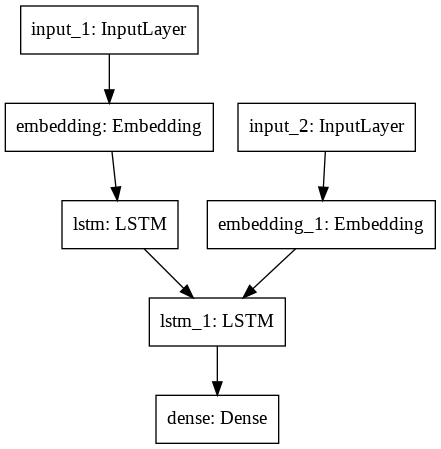

In [ ]:
######################
# Собираем тренировочную модель нейросети
######################
model = Model([encoderInputs, decoderInputs], output)
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy')

print(model.summary()) # выведем на экран информацию о построенной модели нейросети
plot_model(model, to_file='model.png') # и построим график для визуализации слоев и связей между ними

In [ ]:
# Запустим обучение и сохраним модель
model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=50, epochs=400) 
# model.save( '/content/drive/MyDrive/26 Генерация текста/saved-0.h5' )

Epoch 1/400
238/238 [==============================] - 14s 59ms/step - loss: 2.3900
Epoch 2/400
238/238 [==============================] - 14s 58ms/step - loss: 2.0959
Epoch 3/400
238/238 [==============================] - 14s 59ms/step - loss: 2.0196
Epoch 4/400
238/238 [==============================] - 14s 58ms/step - loss: 1.9706
Epoch 5/400
238/238 [==============================] - 14s 58ms/step - loss: 1.9323
Epoch 6/400
238/238 [==============================] - 14s 58ms/step - loss: 1.8971
Epoch 7/400
238/238 [==============================] - 14s 57ms/step - loss: 1.8617
Epoch 8/400
238/238 [==============================] - 14s 58ms/step - loss: 1.8253
Epoch 9/400
238/238 [==============================] - 14s 58ms/step - loss: 1.7904
Epoch 10/400
238/238 [==============================] - 14s 57ms/step - loss: 1.7536
Epoch 11/400
238/238 [==============================] - 14s 57ms/step - loss: 1.7164
Epoch 12/400
238/238 [==============================] - 14s 58ms/step - lo

In [ ]:
start_chat(6)

Задайте вопрос : как дела?
 за да нет, и я не теперь я еще а что вы сказал 
Задайте вопрос : что ты сказал?
 я хочу к вот же он не увидишь. 
Задайте вопрос : ок, ну и ответ
 а ты так это на же все за что? 
Задайте вопрос : привет
 что вы имеете в виду? 
Задайте вопрос : а ничего
 еще я ты уже и все. 
Задайте вопрос : ты кличко?
 я это да, к в как совсем в ни ну, 


## Знаки препинания отдельно

In [ ]:
######################
# Подключаем керасовский токенизатор и собираем словарь индексов
######################

# print(len(questions))
# maxWordsCount = 5000
tokenizer = Tokenizer(filters='"#$%&()*+/<=>@[\\]^_`{|}~\t\n', oov_token='unknown', char_level=False, split=' ')
to_tokenize = '.,:;!?'

for i in range(len(questions)):
  # print(str(type(questions[i]))+ str(i))
  if type(questions[i]) == list:
    questions[i] = re.sub(r'(['+to_tokenize+'])', r' \1', questions[i][0])
  else:
    questions[i] = re.sub(r'(['+to_tokenize+'])', r' \1', questions[i])
for i in range(len(answers)):
  # print(str(type(questions[i]))+ str(i))
  if type(answers[i]) == list:
    answers[i] = re.sub(r'(['+to_tokenize+'])', r' \1', answers[i][0])
  else:
    answers[i] = re.sub(r'(['+to_tokenize+'])', r' \1', answers[i])
# questions = re.sub(r'(['+to_tokenize+'])', r' \1', str(questions))
# answers = re.sub(r'(['+to_tokenize+'])', r' \1', str(answers))
# questions_splited = questions_splited.split()
# answers_splited = answers_splited.split()
# print(len(questions))
tokenizer.fit_on_texts(questions + answers) # загружаем в токенизатор список вопросов-ответов для сборки словаря частотности
vocabularyItems = list(tokenizer.word_index.items()) # список с cодержимым словаря

vocabularySize = len(vocabularyItems)+1 # размер словаря
del vocabularyItems
# print( 'Фрагмент словаря : {}'.format(vocabularyItems[:50]))
# print( 'Размер словаря : {}'.format(vocabularySize))

In [ ]:
######################
# Устанавливаем закодированные входные данные(вопросы)
######################
tokenizedQuestions = tokenizer.texts_to_sequences(questions) # разбиваем текст вопросов на последовательности индексов
maxLenQuestions = max([ len(x) for x in tokenizedQuestions]) # уточняем длину самого большого вопроса
# Делаем последовательности одной длины, заполняя нулями более короткие вопросы
paddedQuestions = pad_sequences(tokenizedQuestions, maxlen=maxLenQuestions, padding='post')

# Предподготавливаем данные для входа в сеть
encoderForInput = np.array(paddedQuestions) # переводим в numpy массив
print('Пример оригинального вопроса на вход : {}'.format(questions[100])) 
print('Пример кодированного вопроса на вход : {}'.format(encoderForInput[100])) 
print('Размеры закодированного массива вопросов на вход : {}'.format(encoderForInput.shape)) 
print('Установленная длина вопросов на вход : {}'.format(maxLenQuestions)) 


Пример оригинального вопроса на вход : Какая же мораль ?
Пример кодированного вопроса на вход : [ 197   23 5740    5    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
Размеры закодированного массива вопросов на вход : (11900, 19)
Установленная длина вопросов на вход : 19


In [ ]:
######################
# Устанавливаем раскодированные входные данные(ответы)
######################
tokenizedAnswers = tokenizer.texts_to_sequences(answers) # разбиваем текст ответов на последовательности индексов
maxLenAnswers = max([len(x) for x in tokenizedAnswers]) # уточняем длину самого большого ответа
# Делаем последовательности одной длины, заполняя нулями более короткие ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers, padding='post')

# Предподготавливаем данные для входа в сеть
decoderForInput = np.array(paddedAnswers) # переводим в numpy массив
print('Пример оригинального ответа на вход: {}'.format(answers[100])) 
print('Пример раскодированного ответа на вход : {}'.format(decoderForInput[100][:30])) 
print('Размеры раскодированного массива ответов на вход : {}'.format(decoderForInput.shape)) 
print('Установленная длина ответов на вход : {}'.format(maxLenAnswers)) 

Пример оригинального ответа на вход: <START> Никакой . Так просто вспомнилось . <END>
Пример раскодированного ответа на вход : [    3   670     2    24    97 10694     2     4     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
Размеры раскодированного массива ответов на вход : (11900, 28)
Установленная длина ответов на вход : 28


In [ ]:
######################
# Раскодированные выходные данные(ответы)
######################
tokenizedAnswers = tokenizer.texts_to_sequences(answers) # разбиваем текст ответов на последовательности индексов
for i in range(len(tokenizedAnswers)) : # для разбитых на последовательности ответов
  tokenizedAnswers[i] = tokenizedAnswers[i][1:] # избавляемся от тега <START>
# Делаем последовательности одной длины, заполняя нулями более короткие ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers , padding='post')

decoderForOutput = utils.to_categorical(paddedAnswers, vocabularySize) # переводим в one hot vector
# decoderForOutput = np.array(oneHotAnswers) # и сохраняем в виде массива numpy

In [ ]:
type(decoderForOutput)

numpy.ndarray

In [ ]:
print('Пример раскодированного ответа на вход : {}'.format(decoderForInput[100][:21]))  
print('Пример раскодированного ответа на выход : {}'.format(decoderForOutput[100][4][:21])) 
print('Размеры раскодированного массива ответов на выход : {}'.format(decoderForOutput.shape))
print('Установленная длина вопросов на выход : {}'.format(maxLenAnswers)) 

Пример раскодированного ответа на вход : [    3   670     2    24    97 10694     2     4     0     0     0     0
     0     0     0     0     0     0     0     0     0]
Пример раскодированного ответа на выход : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Размеры раскодированного массива ответов на выход : (11900, 28, 15337)
Установленная длина вопросов на выход : 28


In [ ]:
######################
# Создадим функцию, которая преобразует вопрос пользователя в последовательность индексов
######################
def strToTokens(sentence: str): # функция принимает строку на вход (предложение с вопросом)
  words = sentence.lower().split() # приводит предложение к нижнему регистру и разбирает на слова
  tokensList = list() # здесь будет последовательность токенов/индексов
  for word in words: # для каждого слова в предложении
    tokensList.append(tokenizer.texts_to_sequences([word])[0][0])  # изменено для неизвестных словарю слов
    # tokensList.append(tokenizer.word_index[word]) # определяем токенизатором индекс и добавляем в список

    # Функция вернёт вопрос в виде последовательности индексов, ограниченной длиной самого длинного вопроса из нашей базы вопросов
  return pad_sequences([tokensList], maxlen=maxLenQuestions , padding='post')

In [ ]:
######################
# Создаем рабочую модель для вывода ответов на запросы пользователя
######################
def makeInferenceModels():
  # Определим модель кодера, на входе далее будут закодированные вопросы(encoderForInputs), на выходе состояния state_h, state_c
  encoderModel = Model(encoderInputs, encoderStates) 

  decoderStateInput_h = Input(shape=(200 ,)) # обозначим размерность для входного слоя с состоянием state_h
  decoderStateInput_c = Input(shape=(200 ,)) # обозначим размерность для входного слоя с состоянием state_c

  decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c] # возьмем оба inputs вместе и запишем в decoderStatesInputs

  # Берём ответы, прошедшие через эмбединг, вместе с состояниями и подаём LSTM cлою
  decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding, initial_state=decoderStatesInputs)
  decoderStates = [state_h, state_c] # LSTM даст нам новые состояния
  decoderOutputs = decoderDense(decoderOutputs) # и ответы, которые мы пропустим через полносвязный слой с софтмаксом

  # Определим модель декодера, на входе далее будут раскодированные ответы (decoderForInputs) и состояния
  # на выходе предсказываемый ответ и новые состояния
  decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)

  return encoderModel , decoderModel

In [ ]:
######################
# Первый входной слой, кодер, выходной слой
######################
encoderInputs = Input(shape=(None , )) # размеры на входе сетки (здесь будет encoderForInput)
# Эти данные проходят через слой Embedding (длина словаря, размерность) 
encoderEmbedding = Embedding(vocabularySize, 200 , mask_zero=True) (encoderInputs)
# Затем выход с Embedding пойдёт в LSTM слой, на выходе у которого будет два вектора состояния - state_h , state_c
# Вектора состояния - state_h , state_c зададутся в LSTM слое декодера в блоке ниже
encoderOutputs, state_h , state_c = LSTM(200, return_state=True)(encoderEmbedding)
encoderStates = [state_h, state_c]

In [ ]:
######################
# Второй входной слой, декодер, выходной слой
######################
decoderInputs = Input(shape=(None, )) # размеры на входе сетки (здесь будет decoderForInput)
# Эти данные проходят через слой Embedding (длина словаря, размерность) 
# mask_zero=True - игнорировать нулевые padding при передаче в LSTM. Предотвратит вывод ответа типа: "У меня все хорошо PAD PAD PAD PAD PAD PAD.."
decoderEmbedding = Embedding(vocabularySize, 200, mask_zero=True) (decoderInputs) 
# Затем выход с Embedding пойдёт в LSTM слой, которому передаются вектора состояния - state_h , state_c
decoderLSTM = LSTM(200, return_state=True, return_sequences=True)
decoderOutputs , _ , _ = decoderLSTM (decoderEmbedding, initial_state=encoderStates)
# И от LSTM'а сигнал decoderOutputs пропускаем через полносвязный слой с софтмаксом на выходе
decoderDense = Dense(vocabularySize, activation='softmax') 
output = decoderDense (decoderOutputs)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 200)    3067400     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 200)    3067400     input_2[0][0]                    
_______________________________________________________________________________________

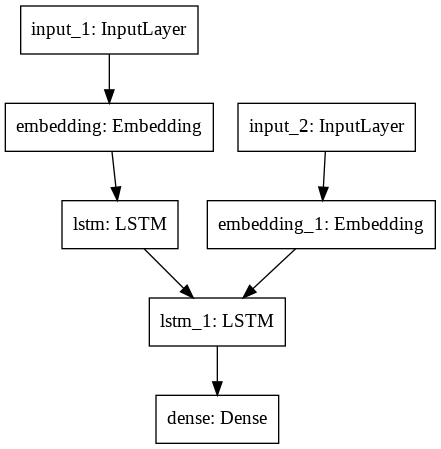

In [ ]:
######################
# Собираем тренировочную модель нейросети
######################
model = Model([encoderInputs, decoderInputs], output)
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy')

print(model.summary()) # выведем на экран информацию о построенной модели нейросети
plot_model(model, to_file='model.png') # и построим график для визуализации слоев и связей между ними

In [ ]:
model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=50, epochs=400) 

Epoch 1/400
238/238 [==============================] - 17s 70ms/step - loss: 0.8144
Epoch 2/400
238/238 [==============================] - 17s 70ms/step - loss: 0.7989
Epoch 3/400
238/238 [==============================] - 17s 70ms/step - loss: 0.7841
Epoch 4/400
238/238 [==============================] - 17s 70ms/step - loss: 0.7690
Epoch 5/400
238/238 [==============================] - 17s 70ms/step - loss: 0.7545
Epoch 6/400
238/238 [==============================] - 17s 70ms/step - loss: 0.7401
Epoch 7/400
238/238 [==============================] - 17s 71ms/step - loss: 0.7257
Epoch 8/400
238/238 [==============================] - 17s 71ms/step - loss: 0.7113
Epoch 9/400
238/238 [==============================] - 17s 70ms/step - loss: 0.6979
Epoch 10/400
238/238 [==============================] - 17s 70ms/step - loss: 0.6849
Epoch 11/400
238/238 [==============================] - 17s 71ms/step - loss: 0.6716
Epoch 12/400
238/238 [==============================] - 17s 70ms/step - lo

In [ ]:
start_chat(6)

Задайте вопрос : как дела ?
 за ночь сделали пятнадцать ничего . 
Задайте вопрос : молодцы ! а почему так мало ?
 не имеет значения . 
Задайте вопрос : ты почему такой дерзкий ?
 что я хочу делаешь в этом тобой ? 
Задайте вопрос : сколько вешать в граммах ?
 двадцать две очень . и джон не каком ним ? 
Задайте вопрос : я не понимаю тебя
 не я не . 
Задайте вопрос : пойдем гулять ?
 оба . . . же не делать , дальше ? 


In [ ]:
start_chat(3)

Задайте вопрос : как дела ?
 за ночь сделали пятнадцать . 
Задайте вопрос : молодцы ! а почему так мало ?
 не слишком поздно . 
Задайте вопрос : ты почему такой дерзкий ?
 да так . 
